#Master equation model of the alanine octapeptide

First we import a number of libraries we will need as we run this example


In [1]:
%load_ext autoreload
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from mastermsm.trajectory import traj
import mdtraj as md
from mastermsm.trajectory import traj_lib
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.2)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###Discretizing the trajectory
We start loading the data using the data structures from the `trajectory` module. For this we use the external library [`MDtraj`](http://mdtraj.org), which contains all sorts of methods for parsing and calculating interestign properties of our time-series data.

In [2]:
tr = traj.TimeSeries(top='data/ALA8_helix_amber03w_wat_min.gro',\
                     traj=['data/traj_whole_s1.xtc'])

In [3]:
print tr.mdt

<mdtraj.Trajectory with 200001 frames, 89 atoms, 10 residues, and unitcells>


For example, we can access the $\phi$ and $\psi$ dihedrals for each of the aminoacids, which we will use in our discretization.

In [4]:
phi = md.compute_phi(tr.mdt)
psi = md.compute_psi(tr.mdt)
res = [x for x in tr.mdt.topology.residues]

For each of the amino acids, we visualize the distribution of Ramachandran angles.

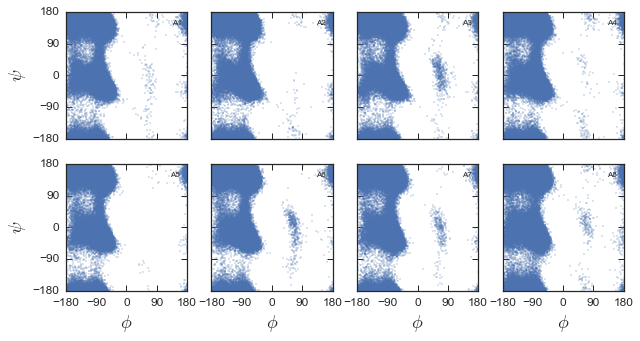

In [5]:
fig,ax = plt.subplots(2,4,figsize=(10,5), sharex=True, sharey=True)
k = 0
for i in range(2):
    for j in range(4):
        ax[i][j].plot(180./math.pi*phi[1][:,k],180./math.pi*psi[1][:,k],\
                      'o', markersize=1, label='A%g'%(k+1))
        ax[i][j].set_xlim(-180,180)
        ax[i][j].set_ylim(-180,180)
        ax[i][j].xaxis.set_ticks(range(-180,181,90))
        ax[i][j].yaxis.set_ticks(range(-180,181,90))
        ax[i][j].legend(fontsize=8)
        #sns.jointplot(180./math.pi*phi[1][:,0],180./math.pi*psi[1][:,0], kind="kde", stat_func=None, ax=ax[i][j])
        k +=1
ax[0][0].set_ylabel(r'$\psi$', fontsize=18)
ax[1][0].set_ylabel(r'$\psi$', fontsize=18)
for j in range(4):
    ax[1][j].set_xlabel(r'$\phi$', fontsize=18)
    

In [6]:
tr.discretize(states=['A', 'E'])

Now we check whether the discretization has captured the relevant dynamics at the single amino acid level. We look into residue 1 and residue 8, as examples.

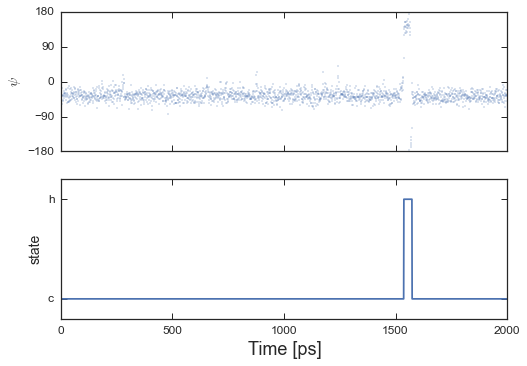

In [7]:
y = [0 if x[0] == 'A' else 1 for x in tr.distraj]
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(psi[1][:,0]*180/math.pi,'o', markersize=1)
ax2.plot(y)
ax1.set_xlim(0,2000)
ax1.set_ylim(-180,180)
ax1.yaxis.set_ticks(range(-180,181,90))
ax1.set_ylabel(r'$\psi$', fontsize=14)

ax2.set_ylabel(r'state', fontsize=14)
ax2.set_xlim(0,2000)
ax2.set_ylim(-0.2,1.2)
ax2.yaxis.set_ticks([0,1])
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels[0] = 'c'
labels[1] = 'h'
ax2.set_yticklabels(labels)

ax2.set_xlabel('Time [ps]')
ax2.set_xlabel(r'Time [ps]', fontsize=18)


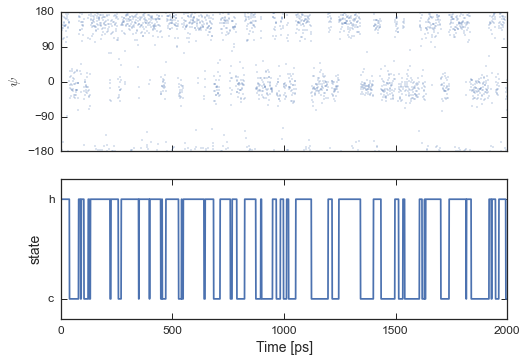

In [8]:
y = [0 if x[7] == 'A' else 1 for x in tr.distraj]
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(psi[1][:,7]*180/math.pi,'o', markersize=1)
ax2.plot(y)

ax1.set_ylabel(r'$\psi$', fontsize=14)
ax1.set_xlim(0,2000)
ax1.set_ylim(-180,180)
ax1.yaxis.set_ticks(range(-180,181,90))

ax2.set_ylabel(r'state', fontsize=14)
ax2.set_xlim(0,2000)
ax2.set_ylim(-0.2,1.2)
ax2.yaxis.set_ticks([0,1])
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels[0] = 'c'
labels[1] = 'h'
ax2.set_yticklabels(labels)

ax2.set_xlabel('Time [ps]')
ax2.set_xlabel(r'Time [ps]', fontsize=14)


In [9]:
tr.find_keys()
tr.keys
tr.file_name

['data/traj_whole_s1.xtc']

In [10]:
from mastermsm.msm import msm
msm_ala8 = msm.SuperMSM([tr])


 Building MSM from 
[['data/traj_whole_s1.xtc']]
     # states: 243


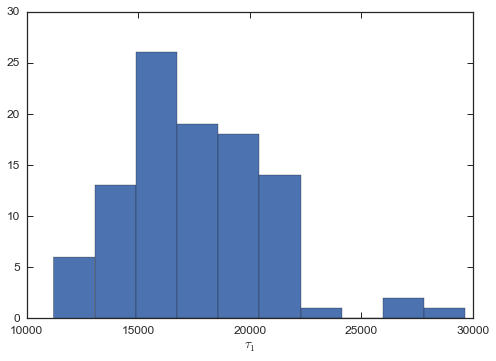

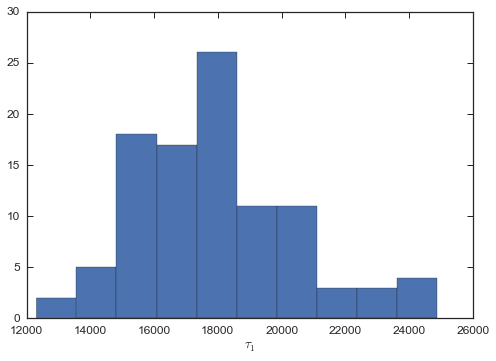

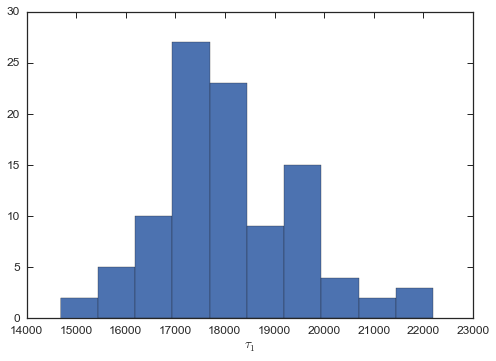

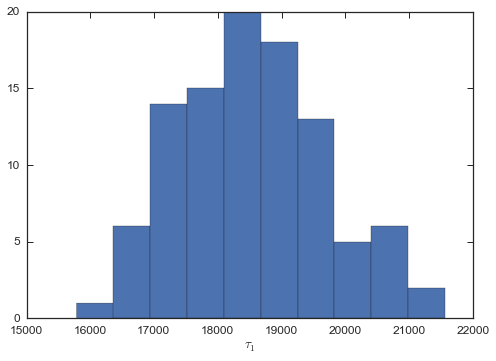

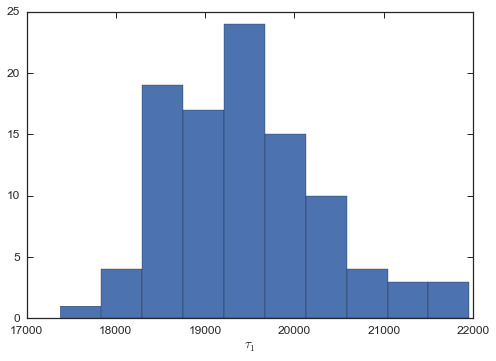

In [11]:
for i in [10, 20, 50, 100, 200]:
    msm_ala8.do_msm(i)
    msm_ala8.msms[i].do_trans()
    msm_ala8.msms[i].boots(plot=False)

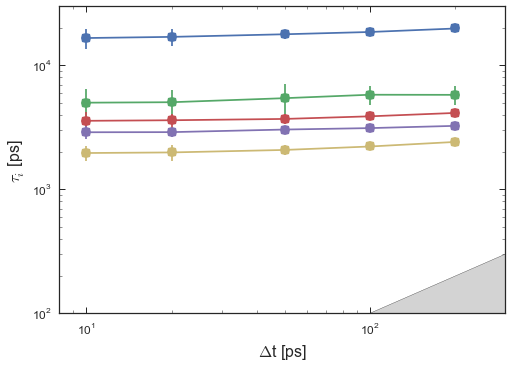

In [24]:
#msm_ala8.convergence_test(time=[10, 20, 50, 100, 200], error=True)
fig, ax = plt.subplots()
for i in range(5):
    tau_vs_lagt = np.array([[x,msm_ala8.msms[x].tauT[i],msm_ala8.msms[x].tau_std[i]] \
               for x in sorted(msm_ala8.msms.keys())])
    ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', yerr=tau_vs_lagt[:,2], markersize=10)
#ax.plot(tau_vs_lagt[:,0],tau_vs_lagt[:,0])
ax.fill_between(10**np.arange(-0.2,3,0.2), 1e-1, 10**np.arange(-0.2,3,0.2), facecolor='lightgray')
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16)
ax.set_ylabel(r'$\tau_i$ [ps]', fontsize=16)
ax.set_xlim(8,300)
ax.set_ylim(1e2,3e4)
_ = ax.set_xscale('log')
_ = ax.set_yscale('log')